In [8]:
# importing necessary libraries

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import re

In [2]:
# importing data

df = pd.read_csv('top3980_flagged.csv')
df = df.dropna(subset=['mktcap_2022', 'revenue_2022'])

In [3]:
# defining matching functions

def perfect_match(df):
    """
    Matches family companies with non-family companies based on country, sector,
    mktcap_2022, and revenue_2022 without replacement.

    Parameters:
    df (pd.DataFrame): The input dataframe with necessary columns.

    Returns:
    tuple: A tuple containing three DataFrames:
        - matched_family (pd.DataFrame): Matched family companies.
        - matched_non_family (pd.DataFrame): Matched non-family companies.
        - matched_sample (pd.DataFrame): Combined DataFrame with matched pairs.
    """

    # Separate family and non-family companies
    family_df = df[df['family'] == 'Family'].copy()
    non_family_df = df[df['family'] == 'Non-Family'].copy()

    # Initialize a set to keep track of matched non-family indices
    matched_non_family_indices = set()

    # List to store matched pairs as tuples (family_idx, non_family_idx)
    matched_pairs = []

    # Group family companies by 'country' and 'sector'
    grouped_family = family_df.groupby(['country', 'sector'])

    # Iterate over each group
    for (country, sector), family_group in grouped_family:
        # Get non-family companies in the same group
        non_family_group = non_family_df[
            (non_family_df['country'] == country) & 
            (non_family_df['sector'] == sector)
        ]

        # Exclude already matched non-family companies
        available_non_family = non_family_group[
            ~non_family_group.index.isin(matched_non_family_indices)
        ]

        if available_non_family.empty:
            # No available non-family companies to match in this group
            continue

        # Features for matching
        X_family = family_group[['mktcap_2022', 'revenue_2022']].values
        X_non_family = available_non_family[['mktcap_2022', 'revenue_2022']].values

        # Scale the features to ensure fair distance calculations
        scaler = StandardScaler()
        scaler.fit(X_non_family)  # Fit on non-family to prevent data leakage
        X_non_family_scaled = scaler.transform(X_non_family)
        X_family_scaled = scaler.transform(X_family)

        # Initialize NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_non_family_scaled)

        # Find the nearest non-family company for each family company
        distances, indices = nbrs.kneighbors(X_family_scaled)

        # Iterate over each family company to assign matches
        for i, (distance, index) in enumerate(zip(distances.flatten(), indices.flatten())):
            family_idx = family_group.index[i]
            non_family_idx = available_non_family.index[index]

            # Check if the non-family company is already matched
            if non_family_idx not in matched_non_family_indices:
                matched_pairs.append((family_idx, non_family_idx))
                matched_non_family_indices.add(non_family_idx)

    # Create DataFrames for matched family and non-family companies
    matched_family = family_df.loc[[pair[0] for pair in matched_pairs]].reset_index(drop=True)
    matched_non_family = non_family_df.loc[[pair[1] for pair in matched_pairs]].reset_index(drop=True)

    # Combine the matched pairs into a single DataFrame with MultiIndex columns
    matched_sample = pd.concat(
        [matched_family, matched_non_family], 
        axis=1, 
        keys=['Family', 'Non-Family']
    )

    return matched_family, matched_non_family, matched_sample

def imperfect_match(df):
    """
    Matches family companies with non-family companies based on sector and country,
    with a two-tiered strategy:
        1. Primary Matching: Same country and sector.
        2. Secondary Matching: Same sector, any country.
    Ensures that every family company is matched with a unique non-family company.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with necessary columns.
    
    Returns:
    tuple: A tuple containing three DataFrames:
        - matched_family (pd.DataFrame): Matched family companies.
        - matched_non_family (pd.DataFrame): Matched non-family companies.
        - matched_sample (pd.DataFrame): Combined DataFrame with matched pairs.
    """
    
    # Separate family and non-family companies
    family_df = df[df['family'] == 'Family'].copy()
    non_family_df = df[df['family'] == 'Non-Family'].copy()
    
    # Initialize a set to keep track of matched non-family indices
    matched_non_family_indices = set()
    
    # List to store matched pairs as tuples (family_idx, non_family_idx)
    matched_pairs = []
    
    # Primary Matching: Same country and sector
    grouped_family = family_df.groupby(['country', 'sector'])
    
    for (country, sector), family_group in grouped_family:
        # Get non-family companies in the same group
        non_family_group = non_family_df[
            (non_family_df['country'] == country) & 
            (non_family_df['sector'] == sector)
        ]
        
        # Exclude already matched non-family companies
        available_non_family = non_family_group[
            ~non_family_group.index.isin(matched_non_family_indices)
        ]
        
        if available_non_family.empty:
            # No available non-family companies to match in this group
            continue
        
        # Features for matching
        X_family = family_group[['mktcap_2022', 'revenue_2022']].values
        X_non_family = available_non_family[['mktcap_2022', 'revenue_2022']].values
        
        # Scale the features to ensure fair distance calculations
        scaler = StandardScaler()
        scaler.fit(X_non_family)  # Fit on non-family to prevent data leakage
        X_non_family_scaled = scaler.transform(X_non_family)
        X_family_scaled = scaler.transform(X_family)
        
        # Initialize NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_non_family_scaled)
        
        # Find the nearest non-family company for each family company
        distances, indices = nbrs.kneighbors(X_family_scaled)
        
        # Iterate over each family company to assign matches
        for i, (distance, index) in enumerate(zip(distances.flatten(), indices.flatten())):
            family_idx = family_group.index[i]
            non_family_idx = available_non_family.index[index]
            
            # Check if the non-family company is already matched
            if non_family_idx not in matched_non_family_indices:
                matched_pairs.append((family_idx, non_family_idx))
                matched_non_family_indices.add(non_family_idx)
    
    # Secondary Matching: Same sector, any country
    # Identify unmatched family companies
    matched_family_indices = set([pair[0] for pair in matched_pairs])
    all_family_indices = set(family_df.index)
    unmatched_family_indices = list(all_family_indices - matched_family_indices)
    
    if unmatched_family_indices:
        # For secondary matching, group unmatched family by sector
        unmatched_family_df = family_df.loc[unmatched_family_indices].copy()
        grouped_unmatched_family = unmatched_family_df.groupby('sector')
        
        for sector, family_group in grouped_unmatched_family:
            # Get non-family companies in the same sector, any country
            non_family_group = non_family_df[
                (non_family_df['sector'] == sector)
            ]
            
            # Exclude already matched non-family companies
            available_non_family = non_family_group[
                ~non_family_group.index.isin(matched_non_family_indices)
            ]
            
            if available_non_family.empty:
                # No available non-family companies to match in this sector
                continue
            
            # Features for matching
            X_family = family_group[['mktcap_2022', 'revenue_2022']].values
            X_non_family = available_non_family[['mktcap_2022', 'revenue_2022']].values
            
            # Scale the features
            scaler = StandardScaler()
            scaler.fit(X_non_family)  # Fit on non-family to prevent data leakage
            X_non_family_scaled = scaler.transform(X_non_family)
            X_family_scaled = scaler.transform(X_family)
            
            # Initialize NearestNeighbors
            nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_non_family_scaled)
            
            # Find the nearest non-family company for each family company
            distances, indices = nbrs.kneighbors(X_family_scaled)
            
            # Iterate over each family company to assign matches
            for i, (distance, index) in enumerate(zip(distances.flatten(), indices.flatten())):
                family_idx = family_group.index[i]
                non_family_idx = available_non_family.index[index]
                
                # Check if the non-family company is already matched
                if non_family_idx not in matched_non_family_indices:
                    matched_pairs.append((family_idx, non_family_idx))
                    matched_non_family_indices.add(non_family_idx)
    
    # Create DataFrames for matched family and non-family companies
    matched_family = family_df.loc[[pair[0] for pair in matched_pairs]].reset_index(drop=True)
    matched_non_family = non_family_df.loc[[pair[1] for pair in matched_pairs]].reset_index(drop=True)
    
    # Combine the matched pairs into a single DataFrame with MultiIndex columns
    matched_sample = pd.concat(
        [matched_family, matched_non_family], 
        axis=1, 
        keys=['Family', 'Non-Family']
    )
    
    return matched_family, matched_non_family, matched_sample


In [4]:
# creating matched samples
perfect_family, perfect_nonfamily, perfect_sample = perfect_match(df)
imperfect_family, imperfect_nonfamily, imperfect_sample = imperfect_match(df)

In [21]:
selected_columns = [
    ("Family", "ticker"),
    ("Family", "company"),
    ("Family", "country"),
    ("Family", "sector"),
    ("Non-Family", "ticker"),
    ("Non-Family", "company"),
    ("Non-Family", "country"),
    ("Non-Family", "sector")
]

# Extracting the subset of the DataFrame
df_selected = imperfect_sample[selected_columns]

In [22]:
eligible_pairs_df = pd.read_csv('/Users/leonardogomes/Library/CloudStorage/GoogleDrive-leodavinci550@gmail.com/My Drive/Elementum/Rob-James/Family_Businesses/eligible_pairs_tickers.csv')

In [107]:

# Ensure df_selected has flat column names
df_selected_flat = df_selected.copy()
df_selected_flat.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_selected_flat.columns]

# Rename columns for merging
df_selected_flat.rename(columns={
    'Family_company': 'Family Company',
    'Family_country': 'Family Country',
    'Family_sector': 'Family Sector',
    'Non-Family_company': 'Non-Family Company',
    'Non-Family_country': 'Non-Family Country',
    'Non-Family_sector': 'Non-Family Sector'
}, inplace=True)

# Merge the dataframes
merged_df = eligible_pairs_df.merge(
    df_selected_flat,
    left_on=["Family", "Non-Family"],
    right_on=["Family_ticker", "Non-Family_ticker"],
    how="left"
)

# Drop the redundant ticker columns from df_selected
merged_df.drop(columns=["Family_ticker", "Non-Family_ticker"], inplace=True)



In [ ]:
# merged_df.to_excel('pairings_data.xlsx')

In [264]:
ciq_sample = pd.read_excel('CIQ_screening_raw.xlsx')
ciq_sample.columns = ciq_sample.columns.str.lower()

In [265]:
ciq_sample['ticker'] = ciq_sample['sp_exchange_ticker'].apply(
    lambda x: x.split(':')[1] if isinstance(x, str) and ':' in x else None
)

In [266]:
# -------------
# Example input:
# -------------
# merged_df has columns:
#   pair_id, Family, Family Company, Family Country, Family Sector,
#   Non-Family, Non-Family Company, Non-Family Country, Non-Family Sector
#
# We want to stack each row into two rows: one for Family, one for Non-Family.

# Create a list to hold the new rows
records = []

# Loop over each row in merged_df
for idx, row in merged_df.iterrows():
    # 1) Build the "Family" record
    family_dict = {
        "pair_id": row["pair_id"],
        "ticker": row["Family"],
        "company": row["Family Company"],
        "country": row["Family Country"],
        "sector": row["Family Sector"],
        "type": "Family"
    }
    records.append(family_dict)
    
    # 2) Build the "Non-Family" record
    non_family_dict = {
        "pair_id": row["pair_id"],
        "ticker": row["Non-Family"],
        "company": row["Non-Family Company"],
        "country": row["Non-Family Country"],
        "sector": row["Non-Family Sector"],
        "type": "Non-Family"
    }
    records.append(non_family_dict)

# Convert list of dicts into a DataFrame
stacked_df = pd.DataFrame(records)

# (Optional) Reorder columns if desired
desired_order = ["pair_id", "ticker", "company", "country", "sector", "type"]
stacked_df = stacked_df[desired_order]

# (Optional) Reset the index for a clean look
stacked_df.reset_index(drop=True, inplace=True)
stacked_df['ticker'] = stacked_df['ticker'].apply(
    lambda x: x.split('.')[0] if isinstance(x, str) and '.' in x else x
)


# ------------------------------------------
# Now `stacked_df` has double the rows of `merged_df`,
# with Family and Non-Family data on separate rows.
# ------------------------------------------


In [267]:
stacked_df

,pair_id,ticker,company,country,sector,type
0,2,RHC,RAMSAY HEALTH CARE LTD,Australia,Health Care,Family
1,2,EBO,EBOS GROUP LTD,Australia,Health Care,Non-Family
2,3,SVW,SEVEN GROUP HOLDINGS LTD,Australia,Industrials,Family
3,3,LLC,LENDLEASE GROUP,Australia,Industrials,Non-Family
4,5,MMK,MAYR-MELNHOF KARTON AG,Austria,Materials,Family
...,...,...,...,...,...,...
187,340,SUI,SUN COMMUNITIES INC,United States,Real Estate,Non-Family
188,344,1184,SAS DRAGON HOLDINGS LTD,Hong Kong,Technology,Family
189,344,2392,CHENG UEI PRECISION INDUSTRY,Taiwan,Technology,Non-Family
190,346,0003,HONG KONG & CHINA GAS,Hong Kong,Utilities,Family


In [268]:
def correct_ticker(ticker):
    # Make sure ticker is a string
    if not isinstance(ticker, str):
        return ticker

    # Case 2: Replace '.' with '-'
    ticker = ticker.replace('.', '-')
    
    # Case 1: For South Korea tickers, if ticker is exactly six digits, prefix with 'A'
    if re.fullmatch(r'\d{6}', ticker):
        ticker = 'A' + ticker

    # Case 3: If ticker is exactly four digits, remove all leading zeros by converting to int
    if re.fullmatch(r'\d{4}', ticker):
        ticker = str(int(ticker))
    
    return ticker

stacked_df['ticker'] = stacked_df['ticker'].apply(correct_ticker)
ciq_sample['ticker'] = ciq_sample['ticker'].apply(correct_ticker)


In [269]:
merged_df2 = pd.merge(stacked_df, ciq_sample, on='ticker', how='left', indicator=True)
remove_tickers = ['SVW', 'LLC', 'GGBR4', 'GOAU4']
merged_df2 = merged_df2[~merged_df2.ticker.isin(remove_tickers)]
unmatched_rows = merged_df2[merged_df2['_merge'] == 'left_only']

# TSR Breakdown

In [272]:
merged_df2.to_excel('sample_with_ciq_data.xlsx')

###########################

In [263]:
# creating combined dfs for plotting

combined_perfect = pd.concat([
    perfect_family[['revenue_2022', 'mktcap_2022', 'family']],
    perfect_nonfamily[['revenue_2022', 'mktcap_2022', 'family']]
], ignore_index=True)

combined_imperfect = pd.concat([
    imperfect_family[['revenue_2022', 'mktcap_2022', 'family']],
    imperfect_nonfamily[['revenue_2022', 'mktcap_2022', 'family']]
], ignore_index=True)

/var/folders/wy/sh80l6n90g521zb1r40wbjs00000gn/T/ipykernel_3011/1803862229.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wy/sh80l6n90g521zb1r40wbjs00000gn/T/ipykernel_3011/1803862229.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


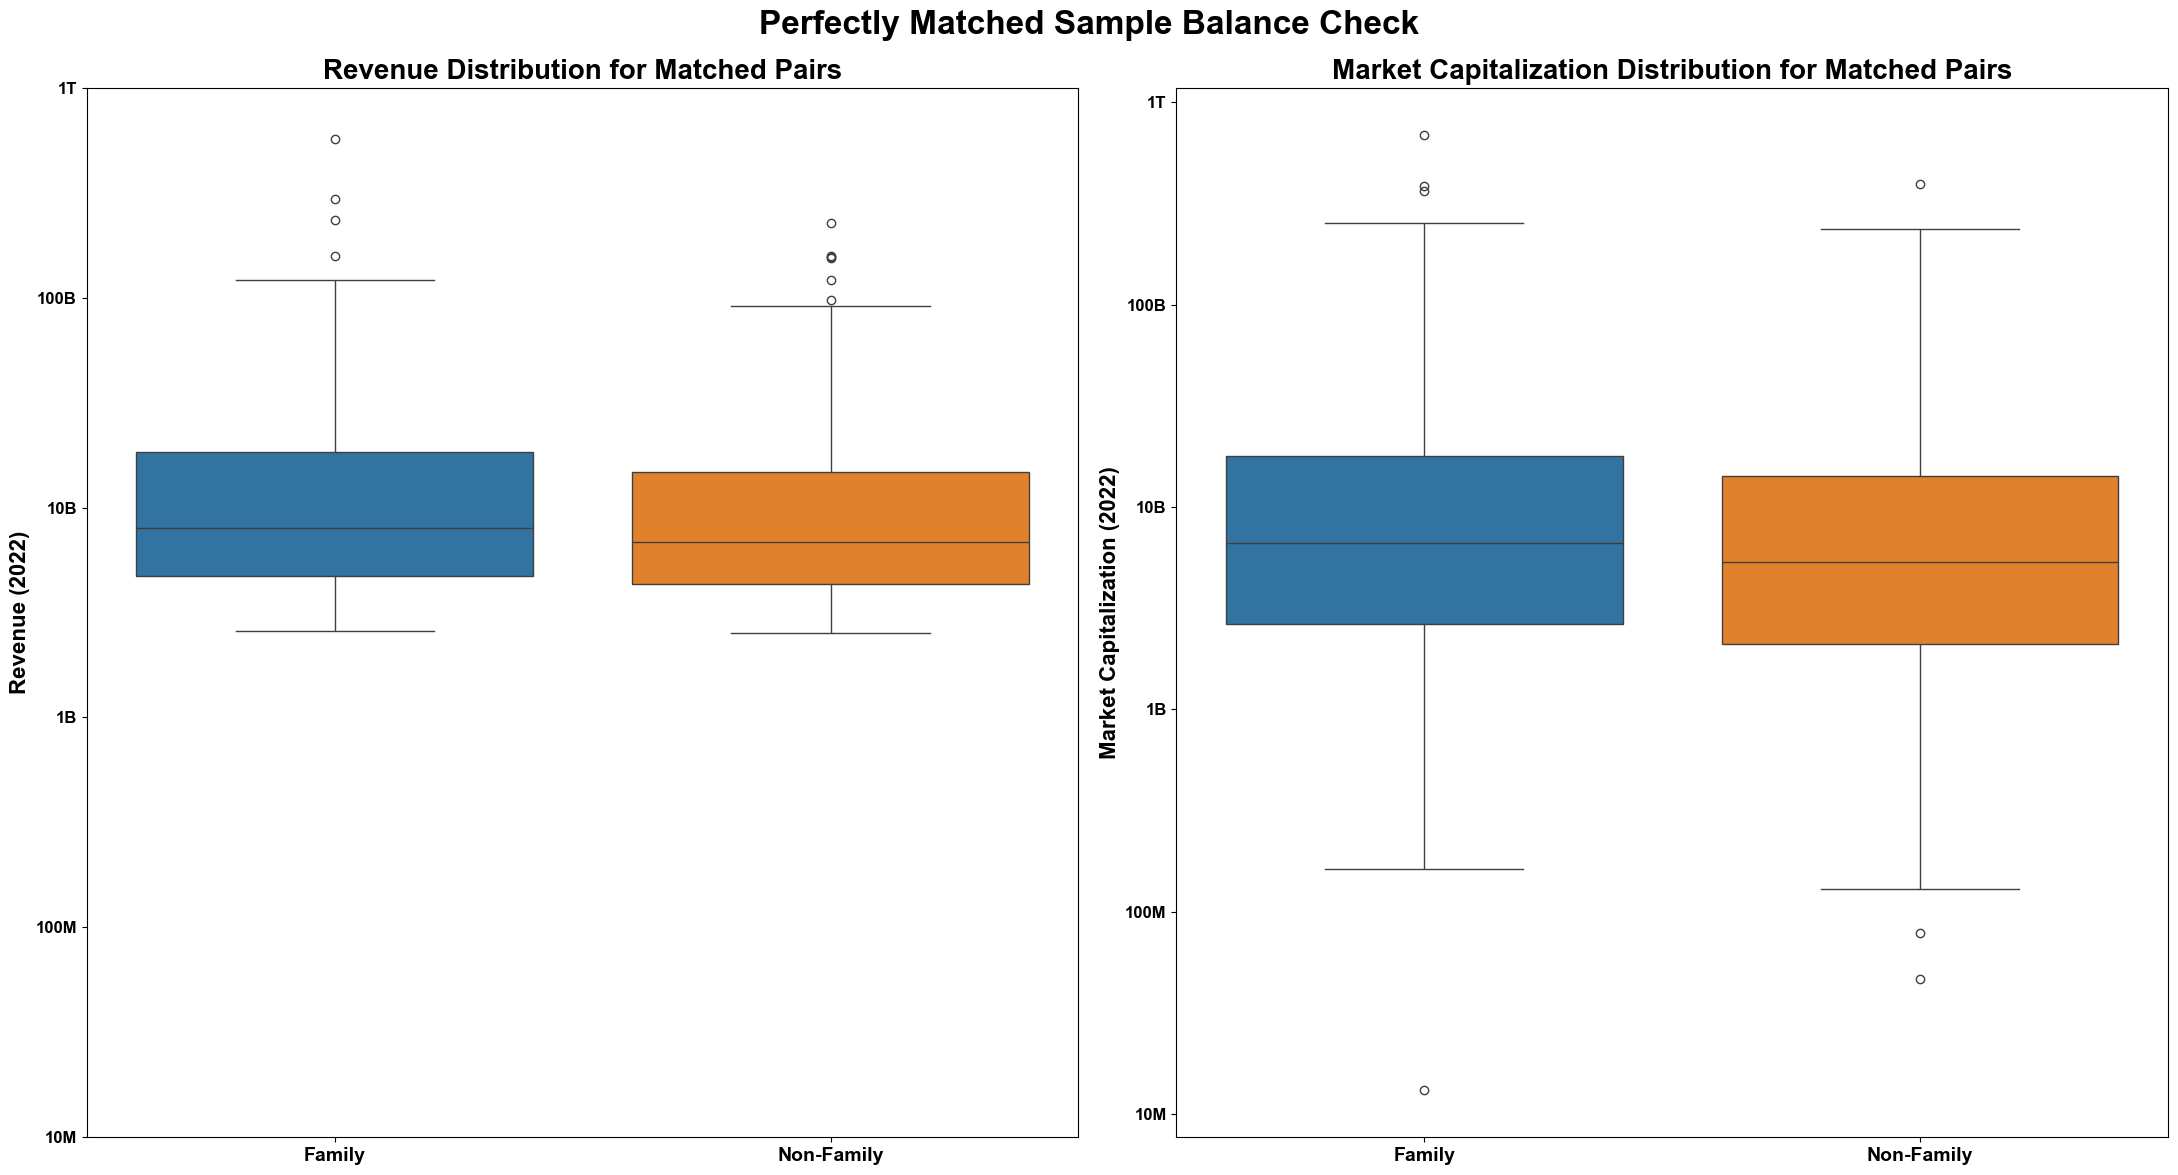

In [6]:
# perfect sample balance check

# Define a professional font
plt.rcParams['font.family'] = 'Arial'  # You can change this to 'Helvetica' or another preferred font
plt.rcParams['font.size'] = 14  # Base font size

# Apply log transformation using log1p to handle zero values
combined_perfect['log_revenue'] = np.log1p(combined_perfect['revenue_2022'])  # log(1 + revenue)
combined_perfect['log_mktcap'] = np.log1p(combined_perfect['mktcap_2022'])    # log(1 + mktcap)

# Remove non-positive entries if any (already handled with log1p)
combined_perfect = combined_perfect[(combined_perfect['revenue_2022'] > 0) & (combined_perfect['mktcap_2022'] > 0)].reset_index(drop=True)

# Define specific colors for each group
palette = ["#1f77b4", "#ff7f0e"]  # Blue for Family, Orange for Non-Family

# Create boxplots for log-transformed values
fig, axes = plt.subplots(1, 2, figsize=(22, 12))  # Increased figure size for better visibility

# Boxplot for Log Revenue
sns.boxplot(
    x='family', 
    y='log_revenue', 
    data=combined_perfect, 
    ax=axes[0], 
    palette=palette
)
axes[0].set_title('Revenue Distribution for Matched Pairs', fontsize=20, fontweight='bold')
axes[0].set_xlabel('', fontsize=16, fontweight='bold')  # Remove x-axis title
axes[0].set_ylabel('Revenue (2022)', fontsize=16, fontweight='bold')

# Boxplot for Log Market Capitalization
sns.boxplot(
    x='family', 
    y='log_mktcap', 
    data=combined_perfect, 
    ax=axes[1], 
    palette=palette
)
axes[1].set_title('Market Capitalization Distribution for Matched Pairs', fontsize=20, fontweight='bold')
axes[1].set_xlabel('', fontsize=16, fontweight='bold')  # Remove x-axis title
axes[1].set_ylabel('Market Capitalization (2022)', fontsize=16, fontweight='bold')

# Define a function to format the y-axis labels correctly
def billions_formatter(x, pos):
    original_value = np.expm1(x)  # Convert back from log1p
    if original_value >= 1e12:
        return f'{original_value/1e12:.1f}T'
    elif original_value >= 1e9:
        return f'{original_value/1e9:.1f}B'
    elif original_value >= 1e6:
        return f'{original_value/1e6:.1f}M'
    else:
        return f'{original_value:.1f}'

# Apply the formatter to both y-axes
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(billions_formatter))
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(billions_formatter))

# Define the ticks at specific positions: 10M, 100M, 1B, 10B, 100B, 1T
tick_values = [np.log1p(10e6), np.log1p(100e6), np.log1p(1e9), 
              np.log1p(10e9), np.log1p(100e9), np.log1p(1e12)]
tick_labels = ['10M', '100M', '1B', '10B', '100B', '1T']

for ax in axes:
    ax.set_yticks(tick_values)  # Set the y-ticks
    ax.set_yticklabels(tick_labels, fontsize=12, fontweight='bold')  # Set custom labels and make them bold
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=12)
    
    # Bold the group names on the x-axis
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')

# Set the overall figure title
fig.suptitle('Perfectly Matched Sample Balance Check', fontsize=24, fontweight='bold')

# Adjust layout for better spacing, leaving space for the legend and title
plt.tight_layout()

# Save the figure with high resolution (optional)
fig.savefig('perfect_match_boxplots.png', dpi=500)

# Display the plots
plt.show()


/var/folders/wy/sh80l6n90g521zb1r40wbjs00000gn/T/ipykernel_3788/1546485117.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wy/sh80l6n90g521zb1r40wbjs00000gn/T/ipykernel_3788/1546485117.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


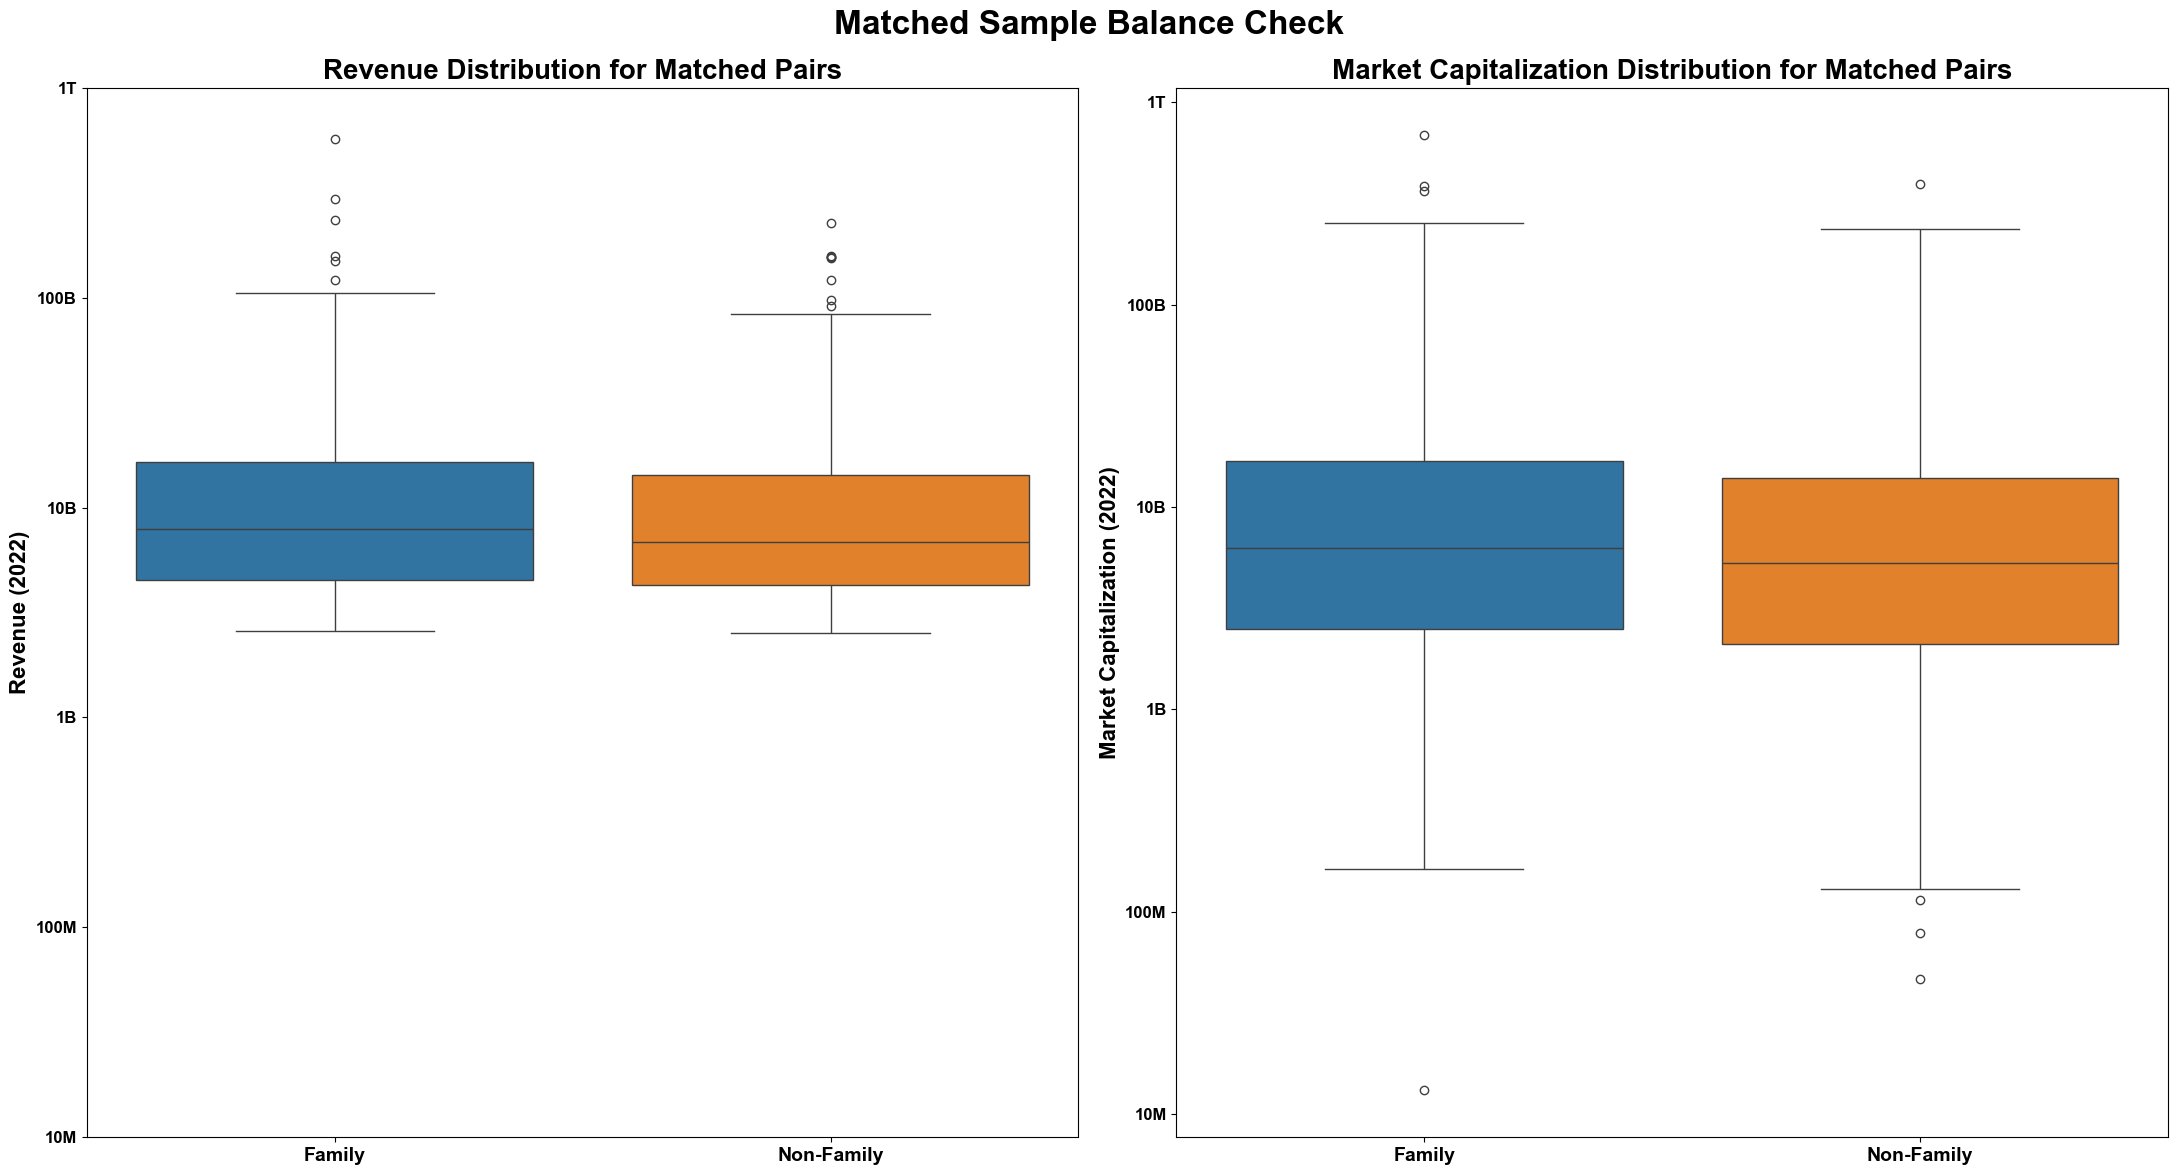

In [7]:
# imperfect sample balance check

# Define a professional font
plt.rcParams['font.family'] = 'Arial'  # You can change this to 'Helvetica' or another preferred font
plt.rcParams['font.size'] = 14  # Base font size

# Apply log transformation using log1p to handle zero values
combined_imperfect['log_revenue'] = np.log1p(combined_imperfect['revenue_2022'])  # log(1 + revenue)
combined_imperfect['log_mktcap'] = np.log1p(combined_imperfect['mktcap_2022'])    # log(1 + mktcap)

# Remove non-positive entries if any (already handled with log1p)
combined_imperfect = combined_imperfect[(combined_imperfect['revenue_2022'] > 0) & (combined_imperfect['mktcap_2022'] > 0)].reset_index(drop=True)

# Define specific colors for each group
palette = ["#1f77b4", "#ff7f0e"]  # Blue for Family, Orange for Non-Family

# Create boxplots for log-transformed values
fig, axes = plt.subplots(1, 2, figsize=(22, 12))  # Increased figure size for better visibility

# Boxplot for Log Revenue
sns.boxplot(
    x='family', 
    y='log_revenue', 
    data=combined_imperfect, 
    ax=axes[0], 
    palette=palette
)
axes[0].set_title('Revenue Distribution for Matched Pairs', fontsize=20, fontweight='bold')
axes[0].set_xlabel('', fontsize=16, fontweight='bold')  # Remove x-axis title
axes[0].set_ylabel('Revenue (2022)', fontsize=16, fontweight='bold')

# Boxplot for Log Market Capitalization
sns.boxplot(
    x='family', 
    y='log_mktcap', 
    data=combined_imperfect, 
    ax=axes[1], 
    palette=palette
)
axes[1].set_title('Market Capitalization Distribution for Matched Pairs', fontsize=20, fontweight='bold')
axes[1].set_xlabel('', fontsize=16, fontweight='bold')  # Remove x-axis title
axes[1].set_ylabel('Market Capitalization (2022)', fontsize=16, fontweight='bold')

# Define a function to format the y-axis labels correctly
def billions_formatter(x, pos):
    original_value = np.expm1(x)  # Convert back from log1p
    if original_value >= 1e12:
        return f'{original_value/1e12:.1f}T'
    elif original_value >= 1e9:
        return f'{original_value/1e9:.1f}B'
    elif original_value >= 1e6:
        return f'{original_value/1e6:.1f}M'
    else:
        return f'{original_value:.1f}'

# Apply the formatter to both y-axes
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(billions_formatter))
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(billions_formatter))

# Define the ticks at specific positions: 10M, 100M, 1B, 10B, 100B, 1T
tick_values = [np.log1p(10e6), np.log1p(100e6), np.log1p(1e9), 
              np.log1p(10e9), np.log1p(100e9), np.log1p(1e12)]
tick_labels = ['10M', '100M', '1B', '10B', '100B', '1T']

for ax in axes:
    ax.set_yticks(tick_values)  # Set the y-ticks
    ax.set_yticklabels(tick_labels, fontsize=12, fontweight='bold')  # Set custom labels and make them bold
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=12)
    
    # Bold the group names on the x-axis
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')

# Set the overall figure title
fig.suptitle('Matched Sample Balance Check', fontsize=24, fontweight='bold')

# Adjust layout for better spacing, leaving space for the legend and title
plt.tight_layout()

# Save the figure with high resolution (optional)
fig.savefig('imperfect_match_boxplots.png', dpi=500)

# Display the plots
plt.show()


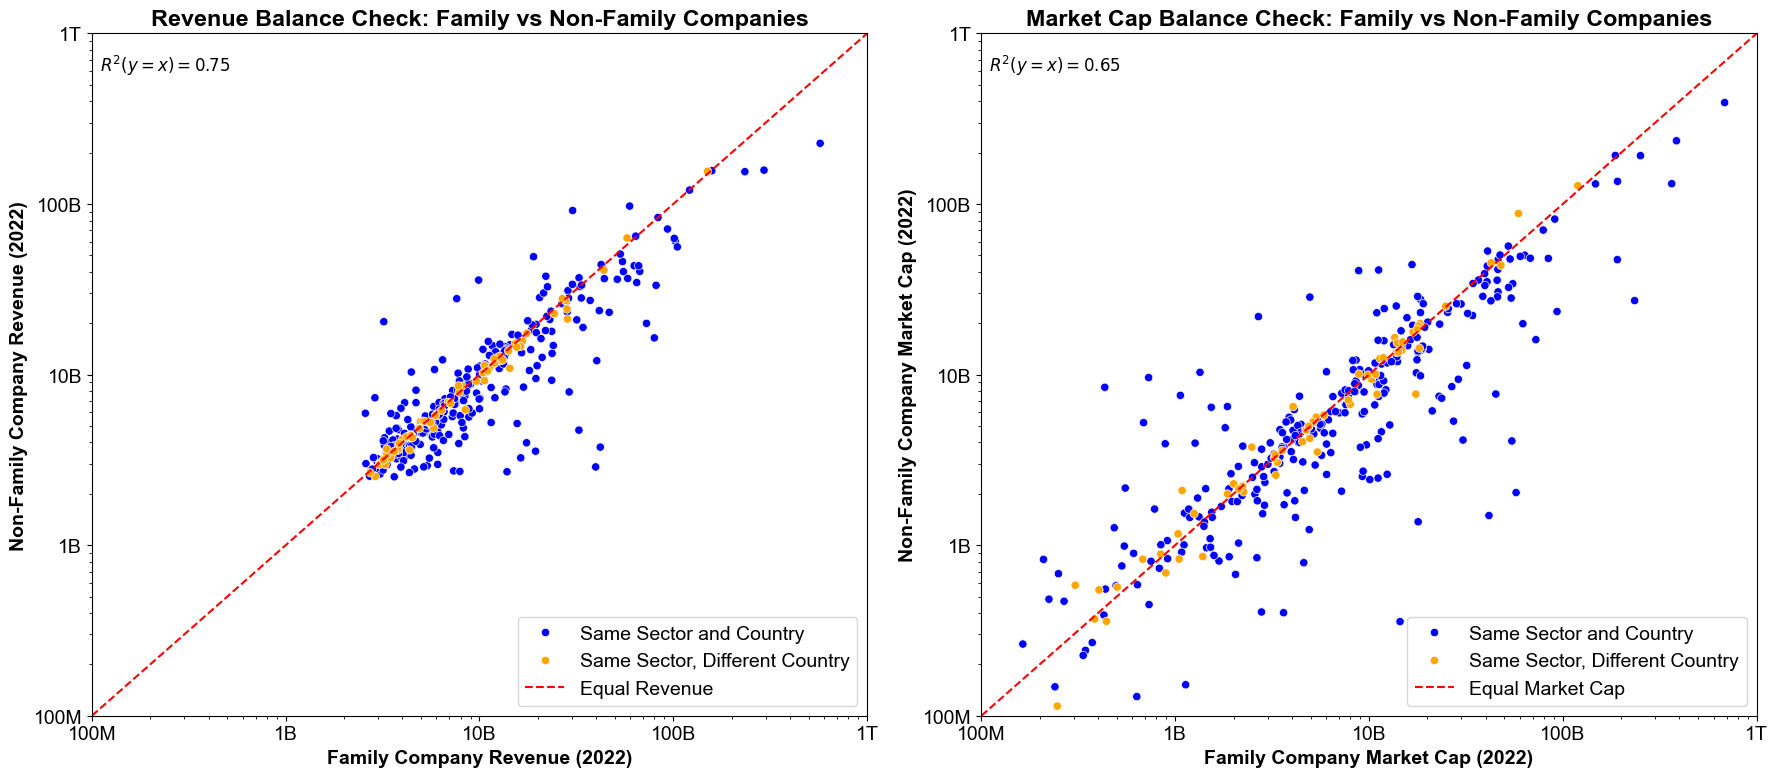

In [8]:
# Define a function to format ticks as trillions (T), billions (B), millions (M), or thousands (K)
def billions_formatter(x, pos):
    if x >= 1e12:
        return f'{x * 1e-12:.0f}T'
    elif x >= 1e9:
        return f'{x * 1e-9:.0f}B'
    elif x >= 1e6:
        return f'{x * 1e-6:.0f}M'
    elif x >= 1e3:
        return f'{x * 1e-3:.0f}K'
    else:
        return f'{x:.0f}'

# Assuming 'imperfect_sample' is your DataFrame with MultiIndex columns

# Extract revenue and market cap data
family_revenue = imperfect_sample[('Family', 'revenue_2022')]
non_family_revenue = imperfect_sample[('Non-Family', 'revenue_2022')]
family_mktcap = imperfect_sample[('Family', 'mktcap_2022')]
non_family_mktcap = imperfect_sample[('Non-Family', 'mktcap_2022')]

# Create a plotting DataFrame and drop missing values
plot_df = pd.DataFrame({
    'Family Revenue': family_revenue,
    'Non-Family Revenue': non_family_revenue,
    'Family Market Cap': family_mktcap,
    'Non-Family Market Cap': non_family_mktcap
}).dropna()

# Add the comparison column for coloring
plot_df['Same Sector and Country'] = (
    (imperfect_sample[('Family', 'sector')] == imperfect_sample[('Non-Family', 'sector')]) &
    (imperfect_sample[('Family', 'country')] == imperfect_sample[('Non-Family', 'country')])
).replace({True: 'Same Sector and Country', False: 'Same Sector, Different Country'}).loc[plot_df.index]

# Calculate R^2 for y = x model for both revenue and market cap
y_revenue_actual = np.log(plot_df['Non-Family Revenue'])
y_revenue_pred = np.log(plot_df['Family Revenue'])
ss_total_revenue = np.sum((y_revenue_actual - y_revenue_actual.mean()) ** 2)
ss_residual_revenue = np.sum((y_revenue_actual - y_revenue_pred) ** 2)
r_squared_revenue = 1 - (ss_residual_revenue / ss_total_revenue)

y_mktcap_actual = np.log(plot_df['Non-Family Market Cap'])
y_mktcap_pred = np.log(plot_df['Family Market Cap'])
ss_total_mktcap = np.sum((y_mktcap_actual - y_mktcap_actual.mean()) ** 2)
ss_residual_mktcap = np.sum((y_mktcap_actual - y_mktcap_pred) ** 2)
r_squared_mktcap = 1 - (ss_residual_mktcap / ss_total_mktcap)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Revenue Comparison Plot
sns.scatterplot(data=plot_df, x='Family Revenue', y='Non-Family Revenue', hue='Same Sector and Country', palette=['blue', 'orange'], ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(1e8, 1e12)
axes[0].set_ylim(1e8, 1e12)
axes[0].plot([1e8, 1e12], [1e8, 1e12], 'r--', label='Equal Revenue')
axes[0].text(1.1e8, 0.6e12, f'$R^2 (y=x) = {r_squared_revenue:.2f}$', fontsize=12, color='black', ha='left')
axes[0].xaxis.set_major_formatter(FuncFormatter(billions_formatter))
axes[0].yaxis.set_major_formatter(FuncFormatter(billions_formatter))
axes[0].set_xlabel('Family Company Revenue (2022)', fontweight='bold')
axes[0].set_ylabel('Non-Family Company Revenue (2022)', fontweight='bold')
axes[0].set_title('Revenue Balance Check: Family vs Non-Family Companies', fontweight='bold')
axes[0].legend(title='')

# Market Cap Comparison Plot
sns.scatterplot(data=plot_df, x='Family Market Cap', y='Non-Family Market Cap', hue='Same Sector and Country', palette=['blue', 'orange'], ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1e8, 1e12)
axes[1].set_ylim(1e8, 1e12)
axes[1].plot([1e8, 1e12], [1e8, 1e12], 'r--', label='Equal Market Cap')
axes[1].text(1.1e8, 0.6e12, f'$R^2 (y=x) = {r_squared_mktcap:.2f}$', fontsize=12, color='black', ha='left')
axes[1].xaxis.set_major_formatter(FuncFormatter(billions_formatter))
axes[1].yaxis.set_major_formatter(FuncFormatter(billions_formatter))
axes[1].set_xlabel('Family Company Market Cap (2022)', fontweight='bold')
axes[1].set_ylabel('Non-Family Company Market Cap (2022)', fontweight='bold')
axes[1].set_title('Market Cap Balance Check: Family vs Non-Family Companies', fontweight='bold')
axes[1].legend(title='')

plt.tight_layout()
plt.show()

# Optional: Save the plot to a file
fig.savefig('revenue_marketcap_comparison.png', dpi=500)


In [6]:
imperfect_sample.to_csv('imperfect_sample.csv')